In [39]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.integrate import quad

In [62]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 定数
nu = 0.01 / np.pi  # 粘性係数
x_min, x_max = -1.0, 1.0
t_min, t_max = 0.0, 1.0

# Neural Network 定義
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer1 = tf.keras.layers.Dense(50, activation="tanh", kernel_initializer="glorot_normal")
        self.hidden_layer2 = tf.keras.layers.Dense(50, activation="tanh", kernel_initializer="glorot_normal")
        self.hidden_layer3 = tf.keras.layers.Dense(50, activation="tanh", kernel_initializer="glorot_normal")
        self.output_layer = tf.keras.layers.Dense(1, kernel_initializer="glorot_normal")

    def call(self, inputs):
        x, t = inputs
        X = tf.concat([x, t], axis=1)
        h = self.hidden_layer1(X)
        h = self.hidden_layer2(h)
        h = self.hidden_layer3(h)
        return self.output_layer(h)

# PDEの残差計算
def pde_residual(model, x, t):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x, t])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x, t])
            u = model([x, t])
        u_x = tape2.gradient(u, x)
        u_t = tape2.gradient(u, t)
        u_xx = tape1.gradient(u_x, x)
    del tape1, tape2
    return u_t + u * u_x - nu * u_xx

# 訓練データ生成
n_collocation = 10000  # Collocation points for PDE residual
n_initial = 100  # Initial condition points
n_boundary = 100  # Boundary condition points

x_collocation = tf.random.uniform((n_collocation, 1), x_min, x_max, dtype=tf.float32)
t_collocation = tf.random.uniform((n_collocation, 1), t_min, t_max, dtype=tf.float32)

x_initial = tf.random.uniform((n_initial, 1), x_min, x_max, dtype=tf.float32)
t_initial = tf.zeros_like(x_initial, dtype=tf.float32)

x_boundary = tf.concat([tf.ones((n_boundary // 2, 1)) * x_min,
                        tf.ones((n_boundary // 2, 1)) * x_max], axis=0)
t_boundary = tf.random.uniform((n_boundary, 1), t_min, t_max, dtype=tf.float32)

# 初期条件 u(x, 0) = -sin(pi * x)
u_initial = -tf.sin(np.pi * x_initial)

# 境界条件 u(-1, t) = u(1, t) = 0
u_boundary = tf.zeros_like(x_boundary)

# 損失関数
def loss_fn(model):
    residual = pde_residual(model, x_collocation, t_collocation)
    residual_loss = tf.reduce_mean(tf.square(residual))

    u_pred_initial = model([x_initial, t_initial])
    initial_loss = tf.reduce_mean(tf.square(u_pred_initial - u_initial))

    u_pred_boundary = model([x_boundary, t_boundary])
    boundary_loss = tf.reduce_mean(tf.square(u_pred_boundary - u_boundary))

    return 0.6 * residual_loss + 0.2 * initial_loss + 0.2 * boundary_loss

# モデルとオプティマイザの設定
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss = loss_fn(model)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# 訓練ループ
epochs = 20000
for epoch in range(epochs):
    loss = train_step()
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy():.6f}")

# 結果のプロット
x_test = np.linspace(x_min, x_max, 256)[:, None].astype(np.float32)
t_test = np.full_like(x_test, 0.5, dtype=np.float32)  # 時刻 t = 0.5 での解
u_pred = model([tf.convert_to_tensor(x_test), tf.convert_to_tensor(t_test)])

# 厳密解があれば計算する（ここでは省略）

# PINNsの結果をプロット
plt.figure(figsize=(8, 6))
plt.plot(x_test, u_pred.numpy(), '--', label="PINN Prediction", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.legend()
plt.title("PINN Solution for Burger's Equation (t = 0.5)")
plt.show()


Epoch 0, Loss: 0.091878
Epoch 1000, Loss: 0.022904
Epoch 2000, Loss: 0.019396
Epoch 3000, Loss: 0.012349
Epoch 4000, Loss: 0.008627
Epoch 5000, Loss: 0.006722
Epoch 6000, Loss: 0.004683
Epoch 7000, Loss: 0.002349


2024-11-26 16:57:22.184680: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Inputs to operation AddN of type AddN must have the same size and shape.  Input 0: [0] != input 1: [10000,50]
	 [[{{node AddN}}]]


InvalidArgumentError: Graph execution error:

Detected at node AddN defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/opt/homebrew/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/opt/homebrew/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/opt/homebrew/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/opt/homebrew/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/homebrew/Cellar/python@3.11/3.11.5/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/opt/homebrew/Cellar/python@3.11/3.11.5/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/opt/homebrew/Cellar/python@3.11/3.11.5/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/opt/homebrew/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/opt/homebrew/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/opt/homebrew/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/opt/homebrew/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/opt/homebrew/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/opt/homebrew/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/opt/homebrew/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/homebrew/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/opt/homebrew/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/opt/homebrew/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/opt/homebrew/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/opt/homebrew/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/opt/homebrew/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/pb/0qtncy2d7q5cp2tqph_b7b4c0000gn/T/ipykernel_42720/4076641437.py", line 89, in <module>

  File "/var/folders/pb/0qtncy2d7q5cp2tqph_b7b4c0000gn/T/ipykernel_42720/4076641437.py", line 81, in train_step

  File "/var/folders/pb/0qtncy2d7q5cp2tqph_b7b4c0000gn/T/ipykernel_42720/4076641437.py", line 63, in loss_fn

  File "/var/folders/pb/0qtncy2d7q5cp2tqph_b7b4c0000gn/T/ipykernel_42720/4076641437.py", line 36, in pde_residual

Inputs to operation AddN of type AddN must have the same size and shape.  Input 0: [0] != input 1: [10000,50]
	 [[{{node AddN}}]] [Op:__inference_train_step_131083]

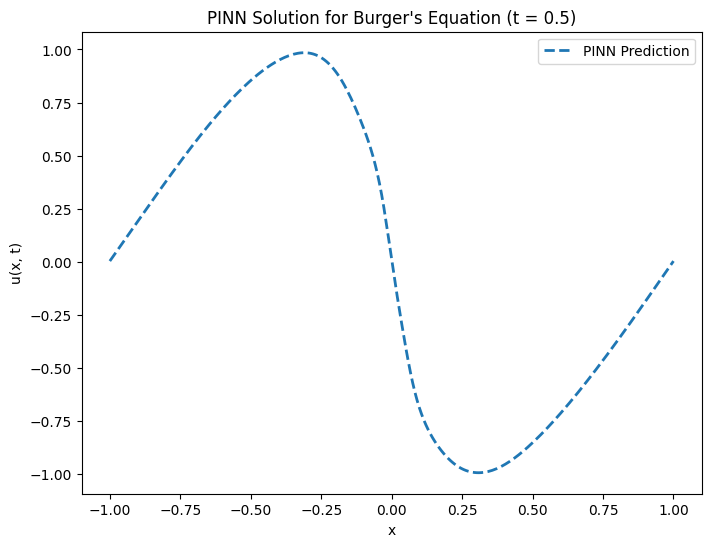

In [60]:
# 結果のプロット
t0 = 0.2
x_test = np.linspace(x_min, x_max, 256)[:, None].astype(np.float32)
t_test = np.full_like(x_test, t0, dtype=np.float32)  # 時刻 t = 0.5 での解
u_pred = model([tf.convert_to_tensor(x_test), tf.convert_to_tensor(t_test)])

plt.figure(figsize=(8, 6))
plt.plot(x_test, u_pred.numpy(), '--', label="PINN Prediction", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.legend()
plt.title("PINN Solution for Burger's Equation (t = 0.5)")
plt.show()


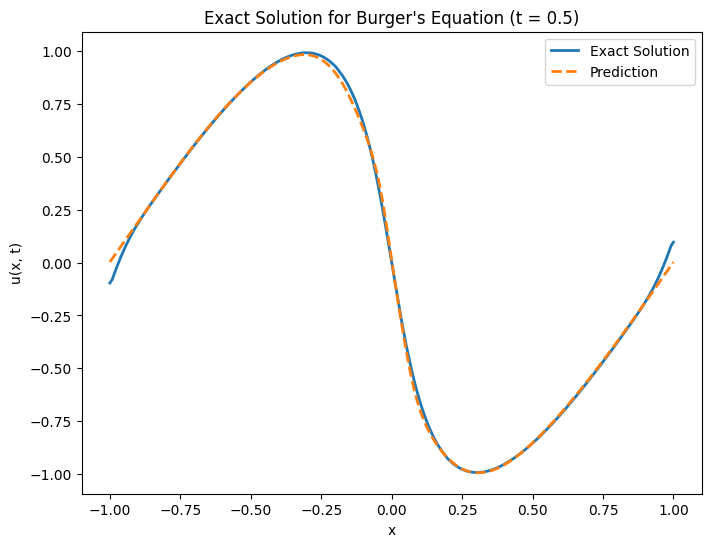

In [61]:
nu = 0.01 / np.pi  # 粘性係数
t_test = t0  # 時刻 t
x_test = np.linspace(-1, 1, 256)  # 空間範囲

# 初期条件に基づく関数 g(xi)
def g_function(xi, nu):
    """
    初期条件に基づく関数 g(xi)
    """
    return np.exp(-np.cos(np.pi * xi) / (2 * np.pi * nu))

# Hopf-Cole変換に基づく θ(x, t) の計算
def theta_function(x, t, nu, tol=1e-8):
    """
    θ(x, t) = ∫ exp(-(x - ξ)^2 / (4νt)) * g(ξ) dξ
    """
    # 有限積分範囲を [-1, 1] に制限
    sigma = np.sqrt(4 * nu * t)
    lower_limit = max(-1, x - 10 * sigma)
    upper_limit = min(1, x + 10 * sigma)

    # θ(x, t) を計算
    integrand = lambda xi: np.exp(-(x - xi)**2 / (4 * nu * t)) * g_function(xi, nu)
    result, error = quad(integrand, lower_limit, upper_limit, epsabs=tol, epsrel=tol)
    return result

# 厳密解 u(x, t) の計算
def burgers_exact(x, t, nu, tol=1e-8):
    """
    Burger's方程式の厳密解を計算
    """
    # θ(x, t) の値を計算
    theta_values = np.array([theta_function(xi, t, nu, tol) for xi in x])
    
    # 勾配を計算（中央差分法を使用）
    theta_dx = np.gradient(np.log(theta_values), x)
    return -2 * nu * theta_dx

# 厳密解を計算
u_exact = burgers_exact(x_test, t_test, nu)

# プロット
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(x_test, u_exact, label="Exact Solution", linewidth=2)
plt.plot(x_test, u_pred, '--', label="Prediction", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.title("Exact Solution for Burger's Equation (t = 0.5)")
plt.legend()
plt.show()